In [2]:
!pip install patchify
!pip install -U segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [3]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.2/303.2 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.17
    Uninstalling albucore-0.0.17:
      Successfully uninstalled albucore-0.0.17
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.17
    Uninstalling albumentations-1.4.17:
      Successfully uninstalled albumentations-1.4.17


In [4]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
import albumentations as A
from PIL import Image
import os
import glob
import cv2
# from albumentations import (
#     Compose, HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate, RandomBrightnessContrast, RandomGamma
# )
from tqdm import tqdm

Apply albumentation on complete dataset and then patchify, keep the images with their names

In [5]:
def get_sorted_filenames(pathname, filetype):
    filenames = []
    filenames = glob.glob(os.path.join(pathname, f"*.{filetype}"))
    filenames.sort()
    print(f"Found {len(filenames)} {filetype} files in {pathname}")
    return filenames

In [6]:
#sorting the masks and the images

# Paths to the images and masks
training_images_path = "/kaggle/input/paip2023/PAIP/PAIP2023_Training"
# combined_masks_path = "/kaggle/input/paip2023/combined_masks"
combined_masks_path = "/kaggle/input/paip2023/combined_otsu"
tumor_binary_path = "/kaggle/input/paip2023/binary_masks/binary_masks/tumor_binary" #later change for otsu binary masks
non_tumor_binary_path = "/kaggle/input/paip2023/binary_masks/binary_masks/non_tumor_binary"

# Call the function and store the results in the variables
non_tumor_train_masks = get_sorted_filenames(non_tumor_binary_path, 'tif')
tumor_train_masks = get_sorted_filenames(tumor_binary_path, "tif")
train_images = get_sorted_filenames(training_images_path, 'png')
# combined_masks = get_sorted_filenames(combined_masks_path, 'tif')
combined_masks = get_sorted_filenames(combined_masks_path, 'png')

Found 53 tif files in /kaggle/input/paip2023/binary_masks/binary_masks/non_tumor_binary
Found 53 tif files in /kaggle/input/paip2023/binary_masks/binary_masks/tumor_binary
Found 53 png files in /kaggle/input/paip2023/PAIP/PAIP2023_Training
Found 53 png files in /kaggle/input/paip2023/combined_otsu


In [7]:
def get_filename(path):
    filename = os.path.basename(path)
    parts = filename.split('_')
    return parts[1] #returning just the id  

In [8]:
def plot_masks(train_image, tumor_mask, non_tumor_mask, combined_mask, filename):
    # Plot the masks and the training image for visualization
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    # Display Training Image
    ax[0].imshow(cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB))  # Convert to RGB for display
    ax[0].set_title("Training Image")
    ax[0].axis('off')
    ax[0].text(0.5, -0.1, f"Filename: {filename}", transform=ax[0].transAxes, ha='center', va='top', fontsize=10, color='black')
    
    # Display Tumor Mask
    ax[1].imshow(tumor_mask, cmap='gray')
    ax[1].set_title("Tumor Mask")
    ax[1].axis('off')
    
    # Display Non-Tumor Mask
    ax[2].imshow(non_tumor_mask, cmap='gray')
    ax[2].set_title("Non-Tumor Mask")
    ax[2].axis('off')
    
    # Display Combined Mask with different colors for different classes
    ax[3].imshow(combined_mask, cmap='jet')
    ax[3].set_title("Combined Mask (Tumor: 1, Non-Tumor: 2)")
    ax[3].axis('off')
    
    plt.tight_layout()
    plt.show()

In [10]:
c1_train_image = cv2.imread(train_images[0])
c1_train_image

array([[[255, 251, 255],
        [255, 251, 255],
        [250, 246, 252],
        ...,
        [208, 166, 189],
        [205, 163, 186],
        [176, 135, 156]],

       [[253, 249, 255],
        [254, 250, 255],
        [252, 248, 254],
        ...,
        [209, 167, 190],
        [215, 174, 195],
        [196, 155, 176]],

       [[253, 249, 255],
        [254, 250, 255],
        [254, 250, 255],
        ...,
        [197, 155, 178],
        [213, 170, 191],
        [208, 166, 184]],

       ...,

       [[225, 213, 233],
        [223, 211, 231],
        [226, 214, 234],
        ...,
        [236, 215, 230],
        [212, 185, 201],
        [196, 164, 181]],

       [[221, 209, 229],
        [220, 208, 228],
        [226, 214, 234],
        ...,
        [216, 190, 204],
        [184, 151, 166],
        [165, 128, 144]],

       [[219, 207, 227],
        [219, 207, 227],
        [227, 215, 235],
        ...,
        [187, 158, 173],
        [172, 135, 151],
        [169, 127, 144]]

In [ ]:
for i in range(5):
    t_path = tumor_train_masks[i]
    nt_path = non_tumor_train_masks[i]
    c_path = combined_masks[i]
    train_image_path = train_images[i]
    
#     print(t_path, nt_path, c_path, train_image_path, sep='\n')
#     print()

    # Load the training image and masks
    train_image = cv2.imread(train_image_path)
    t_mask = tiff.imread(t_path)
    nt_mask = tiff.imread(nt_path)
    # c_mask = tiff.imread(c_path)
    c_mask = cv2.imread(train_image_path, cv2.IMREAD_GRAYSCALE)
    m = c_mask.shape
    # Extract filename (for display purposes)
    filename = get_filename(t_path)
    
    # Plot the images and masks
    plot_masks(train_image, t_mask, nt_mask, c_mask, filename)
print(m)

## Code to Randomly Select Training and Testing Images

In [ ]:
# import random 
# # Set the random seed for reproducibility (optional)
# random.seed(42)

# # Define the proportion of data to use for testing
# test_size = 0.2  # 20% of the data will be used for testing
# num_images = len(train_images)

# # Calculate the number of test images
# num_test_images = int(num_images * test_size)

# # Randomly select test images indices
# test_indices = random.sample(range(num_images), num_test_images)

# # Create training and testing datasets
# x_test_images = [train_images[i] for i in test_indices]
# y_test_images = [combined_masks[i] for i in test_indices]

# # Create training datasets by excluding the test indices
# x_train_images = [train_images[i] for i in range(num_images) if i not in test_indices]
# y_train_images = [combined_masks[i] for i in range(num_images) if i not in test_indices]

# # To check the length of each array
# print("Number of Training Images:", len(x_train_images))
# print("Number of Training Masks:", len(y_train_images))
# print("Number of Testing Images:", len(x_test_images))
# print("Number of Testing Masks:", len(y_test_images))

In [ ]:
# # Loop through all RGB images and their corresponding masks
# i = 1
# for image_filename in train_images:
#     if image_filename.endswith(".png"):
#         print(i, image_filename)
#         i+=1

In [ ]:
# # Loop through all RGB images and their corresponding masks
# i = 1
# for image_filename in combined_masks:
#     if image_filename.endswith(".tif"):
#         print(i, image_filename)
#         i += 1

# Applying Augmentation and then patchify

## Output Directories

In [ ]:
# output_aug_image_dir = '/kaggle/working/images_aug/'
# output_aug_masks_dir = "/kaggle/working/masks_aug/"
output_image_dir = '/kaggle/working/images/'  # Where to store final patches images
output_mask_dir = '/kaggle/working/masks/'    # Where to store final patches masks
# #creating one image output dir
# output_imagec001_dir = '/kaggle/working/imagec001/'  # Where to store imagec001 trial
# output_maskc001_dir = '/kaggle/working/masksc001/'    # Where to store maskc001 trial


In [ ]:
# import shutil

# # Define the path to the directory you want to delete
# def delete_directory(directory_path):

#     directory_to_delete = directory_path
#     # Check if the directory exists
#     if os.path.exists(directory_to_delete):
#         # Remove the directory and all its contents
#         shutil.rmtree(directory_to_delete)
#         print(f"Directory {directory_to_delete} and all its contents have been deleted.")
#     else:
#         print(f"Directory {directory_to_delete} does not exist.")


In [ ]:
# delete_directory("/kaggle/working/images")
# delete_directory("/kaggle/working/masks")
# delete_directory("/kaggle/working/images_aug")
# delete_directory("/kaggle/working/masks_aug")
# delete_directory('/kaggle/working/imagec001/')
# delete_directory('/kaggle/working/masksc001/')

In [ ]:
# Create directories if they don't exist
# os.makedirs(output_aug_image_dir, exist_ok=True)
# os.makedirs(output_aug_masks_dir, exist_ok=True)
# os.makedirs(output_image_dir, exist_ok=True)
# os.makedirs(output_mask_dir, exist_ok=True)
# os.makedirs(output_imagec001_dir, exist_ok=True)
# os.makedirs(output_maskc001_dir, exist_ok=True)

## Applying Augmentation first

In [ ]:
# Define the augmentation pipeline equivalent to your img_data_gen_args
# def get_augmentation_pipeline():
#     return A.Compose([
#         A.RandomRotate90(p=0.5),  # Equivalent to rotation_range=90 in Keras
#         A.Rotate(limit=90, p=0.7),  # Random rotation in a given limit (up to 90 degrees)

#         A.ShiftScaleRotate(
#             shift_limit=0.3,      # Equivalent to width_shift_range and height_shift_range
#             scale_limit=0.3,      # Equivalent to zoom_range
#             rotate_limit=0,       # No additional rotation here, handled above
#             shear_limit=0.5,      # Equivalent to shear_range
#             border_mode=cv2.BORDER_REFLECT,  # Equivalent to fill_mode='reflect'
#             p=1.0
#         ),

#         A.HorizontalFlip(p=0.5),  # Equivalent to horizontal_flip=True
#         A.VerticalFlip(p=0.5),    # Equivalent to vertical_flip=True

#         # ToTensorV2() can be used if you're using PyTorch
#     ])

In [ ]:
# # Augmentation pipeline
# def get_augmentation_pipeline():
#     return Compose([
#         HorizontalFlip(p=0.5),
#         VerticalFlip(p=0.5),
#         RandomRotate90(p=0.5),
#         ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
#         RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
#         RandomGamma(p=0.5)
#     ])

In [ ]:
# def apply_augmentation(train_images, combined_masks):
#     augmentation_pipeline = get_augmentation_pipeline()
#     num_augmentations = 1
#     # Main loop to process each image and mask pair
#     for img_path, mask_path in tqdm(zip(train_images, combined_masks), total=len(train_images)):
        
#         img_name = os.path.basename(img_path).split('.')[0]  # Extract base name without extension

#         # Read image (PNG) and mask (TIF)
#         image = cv2.imread(img_path)  # RGB image
#         mask = tiff.imread(mask_path)  # Grayscale mask
#         # Generate multiple augmentations for each image
#         for n in range(num_augmentations):
#             augmented = augmentation_pipeline(image=image, mask=mask)
#             augmented_image = augmented['image']
#             augmented_mask = augmented['mask']

#             # Create unique filenames for augmented images and masks
#             augmented_image_filename = f"{img_name}_aug_{n}.png"
#             augmented_mask_filename = f"{img_name}_aug_{n}.png"
            
#             # Save the image patch to the output_image_dir
#             cv2.imwrite(os.path.join(output_aug_image_dir, augmented_image_filename), augmented_image)
#             # Save the corresponding mask patch to the output_mask_dir
#             cv2.imwrite(os.path.join(output_aug_masks_dir, augmented_mask_filename), augmented_mask)
            
#             print(f'{augmented_mask_filename} and {augmented_image_filename} saved successfully?')

#     print("augmented masks and images successfully saved")

In [80]:
import albumentations as A
from albumentations.core.composition import BboxParams
import cv2

def get_augmentation_pipeline():
    return A.Compose([
        A.RandomRotate90(p=0.5),
        A.Rotate(limit=90, p=0.7),
        A.ShiftScaleRotate(
            shift_limit=0.3,
            scale_limit=0.3,
            rotate_limit=0,
            shear_limit=0.5,
            border_mode=cv2.BORDER_REFLECT,
            p=1.0
        ),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ])


In [ ]:
import numpy as np
from patchify import patchify, unpatchify
import random

def data_generator(images, masks, patch_size=256, batch_size=4):
    """
    A generator that applies augmentation and patching to images and masks.
    
    Args:
        images (list): List of image file paths or preloaded image arrays.
        masks (list): List of mask file paths or preloaded mask arrays.
        patch_size (int): Size of the patches.
        batch_size (int): Number of patches per batch.
    
    Yields:
        Tuple of (patches, masks) for training.
    """
    # Initialize augmentation pipeline
    augment = get_augmentation_pipeline()
    
    while True:
        # Randomly shuffle data
        indices = list(range(len(images)))
        random.shuffle(indices)
        
        for idx in indices:
            # Load image and mask
            img = images[idx]  # Load image (use cv2.imread if paths are provided)
            mask = masks[idx]  # Load mask
            
            # Apply augmentation
            augmented = augment(image=img, mask=mask)
            img_aug = augmented['image']
            mask_aug = augmented['mask']
            
            # Patchify the image and mask
            img_patches = patchify(img_aug, (patch_size, patch_size, img_aug.shape[2]), step=patch_size)
            mask_patches = patchify(mask_aug, (patch_size, patch_size), step=patch_size)
            
            # Reshape patches into (N, H, W, C) and (N, H, W)
            img_patches = img_patches.reshape(-1, patch_size, patch_size, img_aug.shape[2])
            mask_patches = mask_patches.reshape(-1, patch_size, patch_size)
            
            # Yield patches in batches
            for i in range(0, len(img_patches), batch_size):
                yield img_patches[i:i+batch_size], mask_patches[i:i+batch_size]


### Script that can be used later, to produce images that are not duplicated

In [ ]:
# import cv2
# import os
# import numpy as np
# import tifffile as tiff
# from tqdm import tqdm
# import albumentations as A

# # Define augmentation pipeline
# def get_augmentation_pipeline():
#     return A.Compose([
#         A.RandomRotate90(p=0.5),
#         A.Rotate(limit=90, p=0.7),
#         A.ShiftScaleRotate(
#             shift_limit=0.3,
#             scale_limit=0.3,
#             shear_limit=0.5,
#             border_mode=cv2.BORDER_REFLECT,
#             p=1.0
#         ),
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.RandomBrightnessContrast(p=0.3),  # Adding brightness/contrast
#         A.GaussNoise(p=0.2)  # Adding noise for variation
#     ])

# def apply_augmentation(train_images, combined_masks):
#     augmentation_pipeline = get_augmentation_pipeline()
#     num_augmentations = 5
    
#     # Main loop to process each image and mask pair
#     for img_path, mask_path in tqdm(zip(train_images, combined_masks), total=len(train_images)):
        
#         img_name = os.path.basename(img_path).split('.')[0]  # Extract base name without extension

#         # Read image (PNG) and mask (TIF)
#         image = cv2.imread(img_path)  # RGB image
#         mask = tiff.imread(mask_path)  # Grayscale mask
        
#         augmented_images = set()  # To track saved augmented images

#         # Generate multiple augmentations for each image
#         for n in range(num_augmentations):
#             augmented = augmentation_pipeline(image=image, mask=mask)
#             augmented_image = augmented['image']
#             augmented_mask = augmented['mask']

#             # Create unique filenames for augmented images and masks
#             augmented_image_filename = f"{img_name}_aug_{n}.png"
#             augmented_mask_filename = f"{img_name}_aug_{n}.png"

#             # Check for duplicates before saving
#             if tuple(augmented_image.flatten()) not in augmented_images:
#                 augmented_images.add(tuple(augmented_image.flatten()))
#                 cv2.imwrite(os.path.join(output_aug_image_dir, augmented_image_filename), augmented_image)
#                 cv2.imwrite(os.path.join(output_aug_masks_dir, augmented_mask_filename), augmented_mask)
#                 print(f'{augmented_mask_filename} and {augmented_image_filename} saved successfully?')
#             else:
#                 print(f"Duplicate image found, skipping {augmented_image_filename}")

#     print("Augmented masks and images successfully saved.")



In [ ]:
apply_augmentation(train_images, combined_masks)

In [ ]:
def visualize_augmented_images(image_dir, mask_dir, num_samples=5):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    # Visualize num_samples images and corresponding masks
    plt.figure(figsize=(12, num_samples * 3))

    for i in range(num_samples):
        # Load images and masks by index
        img_path = os.path.join(image_dir, image_files[i])
        mask_path = os.path.join(mask_dir, mask_files[i])
        
        # Read the image and mask
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Mask is grayscale
        
        # Plotting the image and mask
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for visualization
        plt.title(f"Augmented Image {i}")
        plt.axis("off")
        
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')  # Show mask in grayscale
        plt.title(f"Augmented Mask {i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the augmented images and corresponding masks
visualize_augmented_images(output_aug_image_dir, output_aug_masks_dir, num_samples=5)

In [ ]:
output_aug_images = get_sorted_filenames(output_aug_image_dir, 'png')
output_aug_masks = get_sorted_filenames(output_aug_masks_dir, 'png')

# Applying Patchify

In [ ]:
# Function to extract patches using patchify
def extract_patches_with_patchify(image, mask, patch_size=256):
    # Extract patches for image and mask using patchify
    image_patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)
    mask_patches = patchify(mask, (patch_size, patch_size), step=patch_size)  # For single-channel masks
    return image_patches, mask_patches

## Testing for one image

In [ ]:
# doing for one image
# img_path = train_images[0]
# mask_path = combined_masks[0]
# print(img_path, mask_path)
# img_name = os.path.basename(img_path).split('.')[0]
# img_name

In [ ]:
# image = cv2.imread(img_path)  # RGB image
# # mask = tiff.imread(mask_path)  # Grayscale mask
# mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
# image_patches, mask_patches = extract_patches_with_patchify(image, mask)

In [ ]:
# image_patches.shape, mask_patches.shape

In [ ]:
# Save patches with reference to original image
for i in range(image_patches.shape[0]):
    for j in range(image_patches.shape[1]):
        # Extract each patch (for image and mask)
        patch = image_patches[i, j, 0, :, :, :]  # RGB image patch
#             patch = (patch.astype('float32')) / 255.
        mask_patch = mask_patches[i, j, :,:]  # Grayscale mask patch (4D)

        # Construct unique filenames
        patch_filename = f"{img_name}_patch_{i}_{j}.png"
        mask_patch_filename = f"{img_name}_mask_patch_{i}_{j}.png"

        # Save the image patch to the output_image_dir
        # cv2.imwrite(os.path.join(output_imagec001_dir, patch_filename), patch)
        # # Save the corresponding mask patch to the output_mask_dir
        # cv2.imwrite(os.path.join(output_maskc001_dir, mask_patch_filename), mask_patch)

print("Augmentation and patch extraction completed!")

## Applying on complete training_dataset

In [ ]:
# Function to read mask based on file extension
def read_mask(mask_path):
    ext = os.path.splitext(mask_path)[1].lower()  # Get the file extension
    
    if ext == '.tif' or ext == '.tiff':  # If it's a TIF file
        mask = tiff.imread(mask_path)  # Read using tiff
    elif ext == '.png':  # If it's a PNG file
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale PNG
    else:
        raise ValueError(f"Unsupported file format: {ext}")
    
    return mask

In [ ]:
def extract_and_save_patches(train_images, combined_masks):
    

    # Main loop to process each image and mask pair
    for img_path, mask_path in tqdm(zip(train_images, combined_masks), total=len(train_images)):
        img_name = os.path.basename(img_path).split('.')[0]  # Extract base name without extension

        # Read image (PNG) and mask (TIF)
        image = cv2.imread(img_path)  # RGB image
        
        # Read mask (conditionally based on file extension)
        mask = read_mask(mask_path)

        # Extract patches from augmented image and mask using patchify
        image_patches, mask_patches = extract_patches_with_patchify(image, mask)

        # Save patches with reference to original image
        for i in range(image_patches.shape[0]):
            for j in range(image_patches.shape[1]):
                # Extract each patch (for image and mask)
                patch = image_patches[i, j, 0, :, :, :]  # RGB image patch
#                 patch = (patch.astype('float32')) / 255. # Normalize the images
                mask_patch = mask_patches[i, j, :,:]  # Grayscale mask patch (4D)


                # Construct unique filenames
                patch_filename = f"{img_name}_patch_{i}_{j}.png"
                mask_patch_filename = f"{img_name}_mask_patch_{i}_{j}.png"

                # Save the image patch to the output_image_dir
                cv2.imwrite(os.path.join(output_image_dir, patch_filename), patch)
                # Save the corresponding mask patch to the output_mask_dir
                cv2.imwrite(os.path.join(output_mask_dir, mask_patch_filename), mask_patch)

    print("patch extraction completed!")

In [ ]:
extract_and_save_patches(output_aug_images, output_aug_masks)
extract_and_save_patches(train_images, combined_masks)

In [ ]:
# Function to get the number of files in a directory
def count_files_in_directory(directory):
    return len(os.listdir(directory))

In [ ]:
# Get the number of images and masks created
num_images = count_files_in_directory(output_image_dir)
num_masks = count_files_in_directory(output_mask_dir)

print(f"Number of images: {num_images}")
print(f"Number of masks: {num_masks}")

In [ ]:
# Function to visualize patched images with corresponding masks in order
def visualize_patches(image_dir, mask_dir, num_samples=5):
    image_files = sorted(os.listdir(image_dir))  # Sort files to ensure order
    mask_files = sorted(os.listdir(mask_dir))    # Sort files to ensure order
    
    # Ensure we don't exceed the number of available patches
    num_samples = min(num_samples, len(image_files))

    plt.figure(figsize=(15, num_samples * 3))
    
    for i in range(num_samples):
        # Load images
        img_path = os.path.join(image_dir, image_files[i])
        mask_path = os.path.join(mask_dir, mask_files[i])
        
        img = cv2.imread(img_path)  # Read RGB image
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale mask

        # Print the filenames
        print(f"Image: {image_files[i]}, Mask: {mask_files[i]}")
        
        # Plotting
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for visualization
        plt.title(f"Patched Image: {image_files[i]}")
        plt.axis("off")
        
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask, cmap='gray')  # Show mask in grayscale
        plt.title(f"Corresponding Mask: {mask_files[i]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize patched images and corresponding masks in order
visualize_patches(output_image_dir, output_mask_dir, num_samples=10)

## Defining model

In [11]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [12]:
# training_images_path = "/kaggle/working/images"
# training_masks_path = "/kaggle/working/masks"

training_images_path = "/kaggle/input/paip2023/PAIP/PAIP2023_Training"
# training_masks_path = "/kaggle/input/paip2023/combined_masks"
training_masks_path = "/kaggle/input/paip2023/combined_otsu"


In [13]:
training_images = get_sorted_filenames(training_images_path, 'png')
# training_masks = get_sorted_filenames(training_masks_path, 'tif')
training_masks = get_sorted_filenames(training_masks_path, 'png')

Found 53 png files in /kaggle/input/paip2023/PAIP/PAIP2023_Training
Found 53 png files in /kaggle/input/paip2023/combined_otsu


In [ ]:
for i in range(len(training_images)):
    print(training_images[i], training_masks[i], sep='\t')
    if(i > 50):
        break

In [ ]:
# import matplotlib.pyplot as plt
# import cv2

# def plot_image_and_mask(train_image, mask_image, filename):
#     # Plot the training image and mask side by side for visualization
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
#     # Display Training Image
#     ax[0].imshow(cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV default) to RGB
#     ax[0].set_title("Training Image")
#     ax[0].axis('off')
#     ax[0].text(0.5, -0.1, f"Filename: {filename}", transform=ax[0].transAxes, ha='center', va='top', fontsize=10, color='black')
    
#     # Display Corresponding Mask
#     ax[1].imshow(mask_image, cmap='gray')
#     ax[1].set_title("Mask Image")
#     ax[1].axis('off')
    
#     plt.tight_layout()
#     plt.show()


In [14]:
len(training_images)

53

In [15]:
training_images[0]

'/kaggle/input/paip2023/PAIP/PAIP2023_Training/tr_c001.png'

In [16]:
c1_mask_path= training_masks[0]
c1_mask = cv2.imread(c1_mask_path, 0) 
# c1_mask = cv2.cvtColor(c1_mask, cv2.COLOR_RGB2BGR)
np.unique(c1_mask)

array([  0, 128, 255], dtype=uint8)

In [19]:
c1_mask.shape

(1024, 1024)

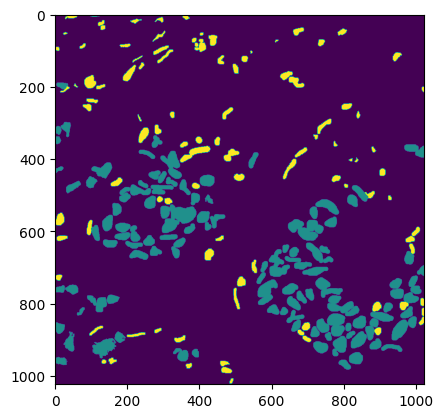

In [22]:
plt.imshow(c1_mask)

In [30]:
def preprocess_mask(mask):
    # mask = cv2.imread(mask_path, 0)  # Grayscale
    mask = np.where(mask == 128, 1, mask)  # Tumor class
    mask = np.where(mask == 255, 2, mask)  # Non-tumor class
    return mask


In [24]:
import cv2
import numpy as np
from PIL import Image
def load_images_and_masks(train_images, train_masks, image_size=(256, 256), num_images=len(training_images)):
    X = []
    y = []

    # Limit the number of images to load
    for img_path, mask_path in zip(train_images[:num_images], train_masks[:num_images]):
        # Load and resize the image
        # img = cv2.imread(img_path)  # Load image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load image
        # img = cv2.resize(img, image_size)  # Resize image to consistent size
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (optional)
        
        # Load and resize the mask
        
        mask = cv2.imread(mask_path, 0)  # Load mask in grayscale
        mask = cv2.resize(mask, image_size)  # Resize mask to consistent size
        # Open the .tif image using Pillow
        # mask_img = Image.open(mask_path)
        # mask = np.array(mask_img)
        # mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        # Add the loaded image and mask to their respective lists
        X.append(img)
        y.append(mask)

    # Convert the lists to NumPy arrays
    X = np.array(X)  # Shape: (num_images, height, width, channels)
    y = np.array(y)  # Shape: (num_images, height, width) -> assuming masks are grayscale

    return X, y

In [25]:
# Example usage:
image_size = (1024, 1024)  # Specify the target image size (can be adjusted)

# Convert your list of image and mask paths into NumPy arrays
X, y = load_images_and_masks(training_images, training_masks, image_size)
# 

In [26]:
X.shape, y.shape

((53, 1024, 1024, 3), (53, 1024, 1024))

In [31]:
y_preprocessed = preprocess_mask(y)

In [33]:
y_preprocessed.shape

(53, 1024, 1024)

In [34]:
np.unique(y_preprocessed)

array([0, 1, 2], dtype=uint8)

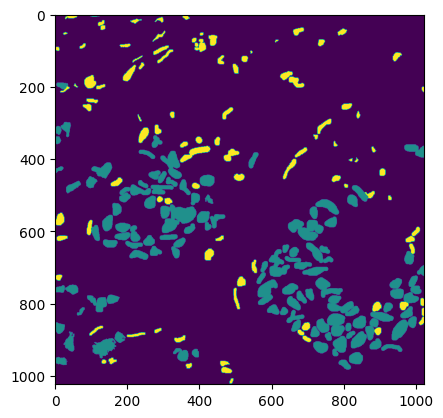

In [35]:
plt.imshow(y_preprocessed[0])

In [36]:
np.unique(y_preprocessed)

array([0, 1, 2], dtype=uint8)

In [37]:
#One hot encoding of masks
from keras.utils import to_categorical
y_cat = to_categorical(y_preprocessed, num_classes=3)

In [38]:
np.unique(y_cat)

array([0., 1.])

In [40]:
y_cat.shape, X.shape

((53, 1024, 1024, 3), (53, 1024, 1024, 3))

In [ ]:
# y = np.expand_dims(y, axis=3)

In [42]:
# y.shape

In [43]:
from sklearn.model_selection import train_test_split


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (42, 1024, 1024, 3)
X_test shape: (11, 1024, 1024, 3)
y_train shape: (42, 1024, 1024, 3)
y_test shape: (11, 1024, 1024, 3)


In [ ]:
# X_train = X_train.astype('float32') / 255.0  # Convert to float32 and normalize
# X_test = X_test.astype('float32') / 255.0    # Convert to float32 and normalize

In [44]:
import segmentation_models as sm
import tensorflow as tf
# Define the model
BACKBONE = 'resnet34'  # Specify your backbone here inceptionv3

Segmentation Models: using `tf.keras` framework.


In [45]:

preprocess_input = sm.get_preprocessing(BACKBONE)
# preprocess input
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [46]:
print(X_train.dtype, X_test.dtype)

uint8 uint8


In [47]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=3, activation='softmax')

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [48]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
model.compile(optimizer = tf.keras.optimizers.Adam(0.00005), 
              loss=sm.losses.DiceLoss(),
              metrics = [sm.metrics.f1_score,
                         sm.metrics.iou_score,
                         ]
             )
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, None,      │      4,096 │ stage1_unit1_rel

 Total params: 24,456,444 (93.29 MB)

 Trainable params: 24,439,094 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

None


In [76]:
np.unique(y_test[0])

array([0., 1.])

In [50]:
y_test.shape

(11, 1024, 1024, 3)

In [51]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (42, 1024, 1024, 3)
y_train shape: (42, 1024, 1024, 3)
X_test shape: (11, 1024, 1024, 3)
y_test shape: (11, 1024, 1024, 3)


In [52]:
history=model.fit(
    X_train,
    y_train,
    batch_size=4,
    epochs=100,
    validation_data=(X_test, y_test),
)

Epoch 1/100


I0000 00:00:1733481395.479493     561 service.cc:145] XLA service 0x7e6024006080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733481395.479571     561 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733481395.479578     561 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-12-06 10:37:38.980891: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,32,1024,1024]{3,2,1,0}, f32[4,16,1024,1024]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-06 10:37:46.607016: E external/local_xla

10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - f1-score: 0.1829 - iou_score: 0.1057 - loss: 0.8171

2024-12-06 10:38:49.792285: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,1024,1024]{3,2,1,0}, f32[2,16,1024,1024]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-06 10:38:50.070458: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.278272087s
Trying algorithm eng0{} for conv (f32[16,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,1024,1024]{3,2,1,0}, f32[2,16,1024,1024]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn

11/11 ━━━━━━━━━━━━━━━━━━━━ 191s 8s/step - f1-score: 0.1838 - iou_score: 0.1064 - loss: 0.8162 - val_f1-score: 0.1154 - val_iou_score: 0.0617 - val_loss: 0.8832
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - f1-score: 0.2247 - iou_score: 0.1347 - loss: 0.7754 - val_f1-score: 0.0876 - val_iou_score: 0.0463 - val_loss: 0.9107
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - f1-score: 0.2567 - iou_score: 0.1589 - loss: 0.7431 - val_f1-score: 0.0905 - val_iou_score: 0.0481 - val_loss: 0.9075
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - f1-score: 0.2921 - iou_score: 0.1859 - loss: 0.7081 - val_f1-score: 0.1052 - val_iou_score: 0.0565 - val_loss: 0.8926
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - f1-score: 0.3294 - iou_score: 0.2143 - loss: 0.6704 - val_f1-score: 0.1244 - val_iou_score: 0.0674 - val_loss: 0.8736
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - f1-score: 0.3371 - iou_score: 0.2242 - loss: 0.6631 - val_f1-score: 0.1393 - val_iou_score: 0.0760 - va

In [68]:
index=5
X_sample = X_train[index]
y_true_sample = y_train[index]  # For sparse, this will have shape (H, W); for categorical, (H, W, num_classes)


In [69]:
# Predict the mask for the selected sample
y_pred_sample = model.predict(np.expand_dims(X_sample, axis=0))  # Expand dimensions to match batch size
y_pred_sample = np.argmax(y_pred_sample, axis=-1)  # Convert probabilities to class indices
y_pred_sample = y_pred_sample[0]  # Remove batch dimension

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [70]:
np.unique(y_pred_sample)

array([0, 1, 2])

In [71]:
y_pred_sample.shape

(1024, 1024)

In [72]:
y_true_sample.shape

(1024, 1024, 3)

In [73]:
if y_true_sample.ndim == 3:  # Shape (H, W, num_classes)
    y_true_sample = np.argmax(y_true_sample, axis=-1)

In [74]:
y_true_sample.shape

(1024, 1024)

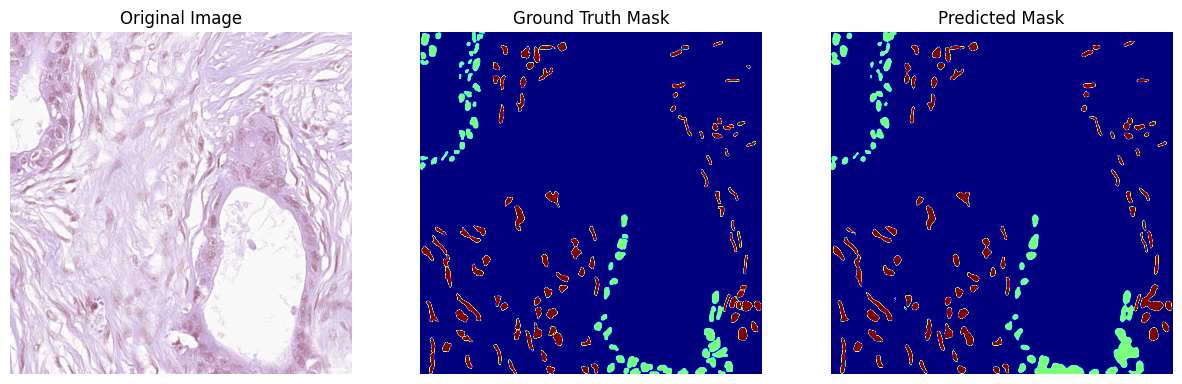

In [75]:

# Plot the images
plt.figure(figsize=(15, 5))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(X_sample.astype('uint8'))  # Convert to uint8 if needed for RGB images
plt.title("Original Image")
plt.axis('off')
# Plot ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(y_true_sample, cmap='jet')  # Use a colormap to differentiate classes
plt.title("Ground Truth Mask")
plt.axis('off')
# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(y_pred_sample, cmap='jet')  # Use the same colormap for consistency
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [77]:
X_train.shape

(42, 1024, 1024, 3)

In [79]:
y_pred = model.predict(X_train)

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_30/514324290.py", line 1, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 504, in predict

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 204, in one_step_on_data_distributed

Out of memory while trying to allocate 9128587280 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  189.29MiB
              constant allocation:         0B
        maybe_live_out allocation:  384.00MiB
     preallocated temp allocation:    8.50GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    9.06GiB
              total fragmentation:  383.59MiB (4.13%)
Peak buffers:
	Buffer 1:
		Size: 4.50GiB
		Operator: op_type="Conv2D" op_name="functional_3_1/decoder_stage2a_conv_1/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: u8[4833607680]
		==========================

	Buffer 2:
		Size: 2.00GiB
		Operator: op_type="Conv2D" op_name="functional_3_1/conv0_1/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,64,512,512]
		==========================

	Buffer 3:
		Size: 1.50GiB
		Operator: op_type="ConcatV2" op_name="functional_3_1/decoder_stage2_concat_1/concat" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: fusion
		Shape: f32[32,192,256,256]
		==========================

	Buffer 4:
		Size: 512.00MiB
		Operator: op_type="Conv2D" op_name="functional_3_1/decoder_stage2a_conv_1/convolution" source_file="/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[32,64,256,256]
		==========================

	Buffer 5:
		Size: 384.00MiB
		Operator: op_type="Softmax" op_name="functional_3_1/softmax_1/Softmax"
		XLA Label: fusion
		Shape: f32[32,1024,1024,3]
		==========================

	Buffer 6:
		Size: 96.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: u8[32,1024,1024,3]
		==========================

	Buffer 7:
		Size: 9.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,512,512]
		==========================

	Buffer 8:
		Size: 9.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,512,512]
		==========================

	Buffer 9:
		Size: 9.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,512,512]
		==========================

	Buffer 10:
		Size: 9.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,512,512]
		==========================

	Buffer 11:
		Size: 9.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,512,512]
		==========================

	Buffer 12:
		Size: 6.75MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,768,256]
		==========================

	Buffer 13:
		Size: 4.50MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,256,512]
		==========================

	Buffer 14:
		Size: 2.25MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,256,256]
		==========================

	Buffer 15:
		Size: 2.25MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,256,256]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_data_distributed_71091]

In [ ]:
y_pred = np.argmax(y_pred_sample, axis=-1)

In [ ]:
y_pred.shape

In [ ]:
# history=model.fit(x=X_train, 
#           y=y_train,
#           batch_size=8, 
#           epochs=100,
#           verbose=1,
#           validation_data=(X_test, y_test))


In [ ]:
# from tensorflow.keras.utils import to_categorical
# y_train_cat = to_categorical(y_train, num_classes =3)
# y_test_cat = to_categorical(y_test, num_classes =3)

In [ ]:
# print(y_train_cat.shape, y_test_cat.shape)

In [ ]:
# Print data types
# print(f"y_train_cat dtype: {y_train_cat.dtype}")  # Should be float32
# print(f"y_test_cat dtype: {y_test_cat.dtype}")    # Should be float32


In [ ]:
# y_train_cat = y_train_cat.astype(np.float32)
# y_test_cat =  y_test_cat.astype(np.float32)

In [ ]:
# # Print data types
# print(f"y_train_cat dtype: {y_train_cat.dtype}")  # Should be float32
# print(f"y_test_cat dtype: {y_test_cat.dtype}")    # Should be float32


In [ ]:
# import pandas as pd
# y_elements_counting = []
# for i in range(3):
#     y_elements_counting.append(np.count_nonzero(y_train==i))
# df=pd.DataFrame(y_elements_counting)

# # claculating class weights
# class_weights = {
#     0: round(sum(y_elements_counting)/y_elements_counting[0],3),
#     1: round(sum(y_elements_counting)/y_elements_counting[1],3),
#     2: round(sum(y_elements_counting)/y_elements_counting[2],3),
# }
# print(class_weights)

In [ ]:
# # sample weights
# sample_weights = np.ones((X_train.shape[0],256,256,3))
# sample_weights[:,:,:,0] = class_weights[0]
# sample_weights[:,:,:,1] = class_weights[1]
# sample_weights[:,:,:,2] = class_weights[2]

In [ ]:
# batch_size = 8

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator


# data_gen = ImageDataGenerator(rescale=1/255.)
# train_gen = data_gen.flow(X_train, y_train_cat, batch_size=batch_size, shuffle=True, seed=100)

# test_datagen = ImageDataGenerator(rescale=1/255.)
# test_gen = test_datagen.flow(X_test, y_test_cat, batch_size=batch_size, shuffle=False, seed=100)


### Custom Data Generator

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def create_data_gen_with_weights(X, y, sample_weights, batch_size):
#     data_gen = ImageDataGenerator(rescale=1/255.)
    
#     # Generate batches of tensor image data with real-time data augmentation.
#     while True:
#         # Randomly shuffle the data
#         indices = np.arange(len(X))
#         np.random.shuffle(indices)
        
#         for start in range(0, len(X), batch_size):
#             end = min(start + batch_size, len(X))
#             batch_indices = indices[start:end]

#             # Get the images and masks for this batch
#             batch_X = X[batch_indices]
#             batch_y = y[batch_indices]
#             batch_weights = sample_weights[batch_indices]

#             yield batch_X, batch_y, batch_weights

# # Create the generators
# train_gen = create_data_gen_with_weights(X_train, y_train_cat, sample_weights, batch_size)
# test_gen = create_data_gen_with_weights(X_test, y_test_cat, sample_weights, batch_size)


In [ ]:
# num_classes=3
# model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=num_classes, activation='softmax')

# model.compile(optimizer = tf.keras.optimizers.Adam(0.00005), 
#               loss=sm.losses.DiceLoss(),
#               metrics = [sm.metrics.f1_score,
#                          sm.metrics.iou_score,
#                          ],
# #               loss_weights = list(class_weights.values())
# #               sample_weight_mode="temporal",
#              )# Use categorical crossentropy for multi-class
# print(model.summary())


In [ ]:
# # Fit the model
# history = model.fit(train_gen, 
#                     validation_data=test_gen, 
#                     steps_per_epoch=len(X_train) // batch_size, 
#                     validation_steps=len(X_test) // batch_size, 
#                     epochs=50)
# Fit the model with the new generator
# history = model.fit(train_gen,
#                     validation_data=test_gen,
#                     steps_per_epoch=len(X_train) // batch_size,
#                     validation_steps=len(X_test) // batch_size,
#                     epochs=100)

In [53]:
# Save the model in HDF5 format
model.save('unet_model.h5')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']
# print(acc, val_acc)

In [ ]:
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test dataset
evaluation= model.evaluate(test_gen,steps=len(X_test) // batch_size, verbose=1)
print(evaluation)
# print(f"Test Loss: {loss}")
# print(f"Test F1 Score: {f1_score}")
# print(f"Test IoU Score: {iou_score}")

In [ ]:
# Predicting on the test dataset
predictions = model.predict(test_gen, steps=len(X_test) // batch_size)

# The output will be in the shape (num_samples, height, width, num_classes)
# If you want to convert predictions to class labels (combined mask), use argmax
predicted_masks = np.argmax(predictions, axis=-1)  # This will give you the predicted class for each pixel

# If you want to convert it back to the original shape of the input images
predicted_masks = np.expand_dims(predicted_masks, axis=-1)  # Shape: (num_samples, height, width, 1)

In [ ]:
# Predicting on the test dataset
predictions = model.predict(train_gen, steps=len(X_train) // batch_size)

# The output will be in the shape (num_samples, height, width, num_classes)
# If you want to convert predictions to class labels (combined mask), use argmax
predicted_masks = np.argmax(predictions, axis=-1)  # This will give you the predicted class for each pixel

# If you want to convert it back to the original shape of the input images
predicted_masks = np.expand_dims(predicted_masks, axis=-1)  # Shape: (num_samples, height, width, 1)

In [ ]:
np.unique(predicted_masks)


In [ ]:
X_train.shape

In [ ]:
# Visualizing specific indices to debug
sample_index = 5  # Change this index to test with different samples
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(X_train[sample_index])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(np.argmax(y_train_cat[sample_index], axis=-1), cmap='jet')
plt.title("Actual Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted_masks[sample_index], cmap='jet')
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Assuming `predictions` is your model's predictions for the test set
# If `y_pred` is already defined as the model predictions, use it directly.
# Example: y_pred = model.predict(test_gen)

# Let's visualize a specific index (ensure `inx` is defined)
inx = 8  # Change this index to visualize different samples

# Get the unique classes in the predicted mask
unique_classes = np.unique(np.argmax(predictions[inx], axis=-1))
print("Unique classes in predicted mask:", unique_classes)

# Set up the figure for visualization
plt.figure(figsize=(25, 5))

# Display the predicted mask (combined mask)
plt.subplot(1, 6, 1)
plt.imshow(np.argmax(predictions[inx], axis=-1), cmap='jet')  # Combined predicted mask
plt.title("Predicted Combined Mask")
plt.axis("off")

# Display each individual class prediction
for i in range(1, len(unique_classes)):
    plt.subplot(1, 6, i + 1)
    plt.imshow(predictions[inx, :, :, i - 1], cmap='jet')  # Individual class prediction
    plt.title(f"Class {i - 1} Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,2.5)
plt.show()

In [ ]:
# test_gen.reset()
# model.evaluate(test_gen)

In [ ]:
# y_pred = model.predict(test_gen)
# y_pred.shape

In [ ]:
print(y_pred.min(), y_pred.max())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming y_test_cat is your true labels (ground truth) and predictions is your model's output
# First, we need to reshape both true and predicted masks to be flat
y_true_flat = np.argmax(y_test_cat, axis=-1).reshape(-1)  # Ground truth
y_pred_flat = np.argmax(predictions, axis=-1).reshape(-1)  # Model predictions

# Define a function to compute the confusion matrix
def confusion_matrix(y_true, y_pred, num_classes=None):
    if num_classes is None:
        num_classes = max(max(y_true), max(y_pred)) + 1
    cm = num_classes * y_true + y_pred
    cm = np.bincount(cm, minlength=num_classes * num_classes)
    cm = cm.reshape(num_classes, num_classes)
    return cm

# Compute the confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Display the confusion matrix using sklearn's ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                     display_labels=["Background", "Tumor", "Non-Tumor"])  # Update with your class names



In [ ]:
# inx = 20
# plt.imshow(test_gen.x[inx])

In [ ]:
# Define the batch size explicitly
batch_size = 8  # Adjust this to your actual batch size

inx = 20  # Index of the image you want to visualize

# Fetch the first batch from the generator
batch = next(iter(test_gen))  # Get the first batch from the generator

# Access images and masks based on the length of the batch
test_image = batch[0]  # First element is images
test_mask = batch[1]   # Second element is masks

# Determine the index within the batch
within_batch_index = inx % batch_size  # This gives the index within the batch

# Access the specific image and mask
image_to_plot = test_image[within_batch_index]  # Get the specific image from the batch
mask_to_plot = test_mask[within_batch_index]    # Get the corresponding mask

# Plotting the images and masks
plt.figure(figsize=(25, 4))

# Plot the original image
plt.subplot(1, 6, 1)
plt.imshow(image_to_plot)
plt.title("Original Image")
plt.axis("off")

# Plot the masks for each channel in the mask
for i in range(mask_to_plot.shape[2]):  # Loop through the number of channels in the mask
    plt.subplot(1, 6, i + 2)  # Subplots for masks
    plt.imshow(mask_to_plot[:, :, i])  # Show the mask for the i-th class
    plt.title(f"Mask {i + 1}")
    plt.axis("off")

plt.show()


In [ ]:
# Inspect the output of the generator
for batch in test_gen:
    print("Batch Length:", len(batch))  # Print the number of elements in the batch
    print("Batch Shape:", [item.shape for item in batch])  # Print the shapes of each item
    break  # Exit after the first batch to avoid long output


In [ ]:
print(np.unique(np.argmax(test_gen.y[inx],axis=2)))
plt.figure(figsize=(25,4))
for i in range(4):
  plt.subplot(1,6,i+1)
  if i>0:
    plt.imshow(test_gen.y[inx,:,:,i-1])
  else:
    plt.imshow(np.argmax(test_gen.y[inx],axis=2))

In [ ]:
print(np.unique(np.argmax(y_pred[inx],axis=2)))
plt.figure(figsize=(25,4))
for i in range(4):
  plt.subplot(1,6,i+1)
  if i>0:
    plt.imshow(y_pred[inx,:,:,i-1])
  else:
    plt.imshow(np.argmax(y_pred[inx],axis=2))

## ZIPPING FINAL DATASET

In [ ]:
import shutil

# Define the path for the zip file
zip_file_path = '/kaggle/working/output_images.zip'

# Zip the folder (output_image_dir)
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', output_image_dir)

print(f"Zipped {output_image_dir} as {zip_file_path}")


In [ ]:
import shutil

# Define the path for the zip file
zip_file_path = '/kaggle/working/output_masks.zip'

# Zip the folder (output_image_dir)
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', output_mask_dir)

print(f"Zipped {output_mask_dir} as {zip_file_path}")


In [ ]:
# # Define augmentations
# augment = A.Compose([
#     A.HorizontalFlip(p=0.5),          # 50% chance to apply horizontal flip
#     A.VerticalFlip(p=0.5),            # 50% chance to apply vertical flip
#     A.RandomRotate90(p=0.5),          # 50% chance to rotate by 90 degrees
#     A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=0.5, border_mode=0) # Random shifts and rotations
# ])


In [ ]:
# # Function to extract patches
# def extract_patches(image, mask, patch_size=256, stride=256):
#     patches = []
#     mask_patches = []
#     h, w, _ = image.shape
#     for i in range(0, h - patch_size + 1, stride):
#         for j in range(0, w - patch_size + 1, stride):
#             patch = image[i:i + patch_size, j:j + patch_size]
#             mask_patch = mask[i:i + patch_size, j:j + patch_size]
#             patches.append(patch)
#             mask_patches.append(mask_patch)
#     return patches, mask_patches

In [ ]:
# augmentation_pipeline = get_augmentation_pipeline()

# # Main loop to process each image and mask pair
# for img_path, mask_path in tqdm(zip(train_images, combined_masks), total=len(train_images)):
#     img_name = os.path.basename(img_path).split('.')[0]
    
#     # Read image and mask
#     image = cv2.imread(img_path)
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Assuming mask is single-channel

#     # Apply augmentations (here we apply augmentations to both image and mask)
#     augmented = augmentation_pipeline(image=image, mask=mask)
#     aug_image = augmented['image']
#     aug_mask = augmented['mask']

#     # Extract patches from augmented image and mask
#     patches, mask_patches = extract_patches(aug_image, aug_mask)

#     # Save patches with reference to original image
#     for idx, (patch, mask_patch) in enumerate(zip(patches, mask_patches)):
#         patch_filename = f"{img_name}_patch_{idx}.png"
#         mask_patch_filename = f"{img_name}_mask_patch_{idx}.png"
        
#         # Save the image patch
#         cv2.imwrite(os.path.join(output_dir, patch_filename), patch)
#         # Save the corresponding mask patch
#         cv2.imwrite(os.path.join(output_dir, mask_patch_filename), mask_patch)

# print("Augmentation and patch extraction completed!")

In [ ]:
# image_patches.shape, mask_patches.shape

In [ ]:
# # Function to visualize patched images with corresponding masks in order
# def visualize_patches(image_dir, mask_dir, num_samples=5):
#     image_files = sorted(os.listdir(image_dir))  # Sort files to ensure order
#     mask_files = sorted(os.listdir(mask_dir))    # Sort files to ensure order
    
#     # Ensure we don't exceed the number of available patches
#     num_samples = min(num_samples, len(image_files))

#     plt.figure(figsize=(15, num_samples * 3))
    
#     for i in range(num_samples):
#         # Load images
#         img_path = os.path.join(image_dir, image_files[i])
#         mask_path = os.path.join(mask_dir, mask_files[i])
        
#         img = cv2.imread(img_path)  # Read RGB image
#         mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read grayscale mask
        
#         # Plotting
#         plt.subplot(num_samples, 2, 2*i + 1)
#         plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for visualization
#         plt.title("Patched Image")
#         plt.axis("off")
        
#         plt.subplot(num_samples, 2, 2*i + 2)
#         plt.imshow(mask, cmap='gray')  # Show mask in grayscale
#         plt.title("Corresponding Mask")
#         plt.axis("off")
    
#     plt.tight_layout()
#     plt.show()

# # Visualize patched images and corresponding masks in order
# visualize_patches(output_imagec001_dir, output_maskc001_dir, num_samples=10)
